# Quickstart: Deploy [UL2](https://arxiv.org/abs/2205.05131) model on a GCE VM with GPUs using NVIDIA Triton Inference server with NVIDIA FasterTransformers backend

This guide demonstrates deploying large Transformer models such as [UL2 (20B) model](https://arxiv.org/abs/2205.05131) locally on a Google Compute Engine VM with A100-40GB GPUs. In this case, we are using [Vertex AI Workbench - User Managed Notebook instance](https://cloud.google.com/vertex-ai/docs/workbench/user-managed/introduction). The model is deployed using NVIDIA Triton Inference server with FasterTransformer backend. 

[NVIDIA Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server) is an open-source inference serving software to standardize model deployment and execution, delivering fast and scalable AI in production. Triton supports models using multiple backends such as PyTorch, TorchScript, Tensorflow, ONNX Runtime, OpenVINO and others. 

Triton has a backend for large Transformer based models called [NVIDIA’s FasterTransformer (FT)](https://github.com/NVIDIA/FasterTransformer/). FT is a library implementing an accelerated engine for the inference of transformer-based neural networks, with a special emphasis on large models, spanning many GPUs and nodes in a distributed manner. FasterTransformer contains the implementation of the highly-optimized version of the transformer block that contains the encoder and decoder parts. 

This section presents the main steps of the workflow to run UL2 model in optimized inference using the FasterTransformer backend in Triton Inference server:

1. Get JAX checkpoints of pretrained or fine-tuned UL2 model.
2. Run conversion tool to convert JAX checkpoint to FasterTransformer format.
3. Deploy the UL2 model (FT format) on GPUs using NVIDIA Triton Inference server with FasterTransformer backend.
4. Run client script to send requests to the Triton server with accelerated models

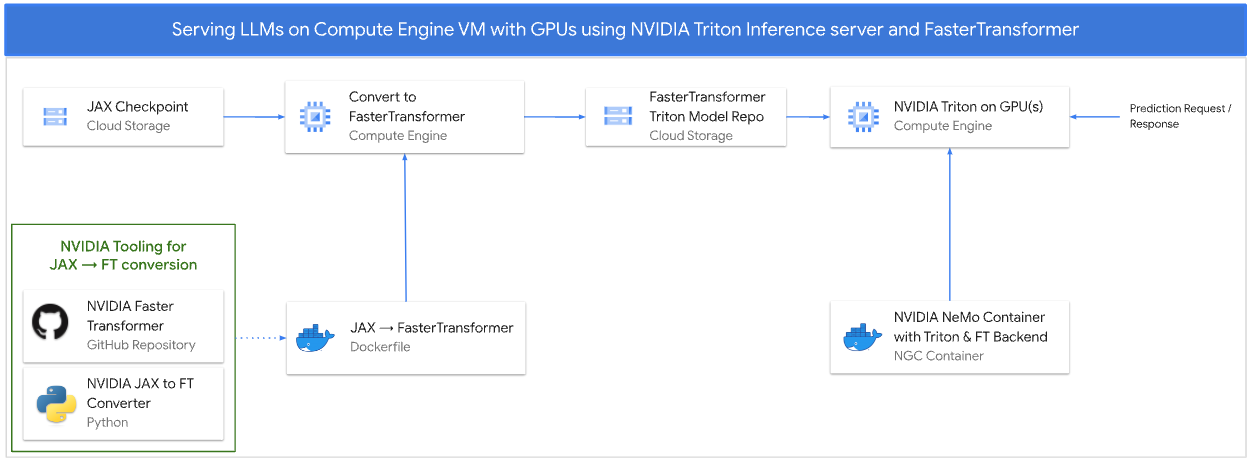

All the steps are run using Docker containers for reproducibility and the notebook contains instructions to build these Docker containers  using Google Cloud Build and Google Cloud Artifact Registry.

<div class="alert alert-block alert-warning"> 
    <p>
        <strong>⚠️ Caution: </strong>
        For production environment, we recommend configuring NVIDIA Triton Inference server on <a href=https://github.com/jarokaz/triton-on-gke-sandbox> Google Kubernetes Engine (GKE)</a> or <a href=https://cloud.google.com/vertex-ai/docs/predictions/using-nvidia-trito>Vertex AI Prediction</a>
    </p>
</div>

---

## Setup environment

### Create Notebook instance

Create Verex AI Workbench User Managed Notebook instance using the following command:

```
gcloud notebooks instances create nb-llm-triton-00 \
    --vm-image-project=deeplearning-platform-release \
    --vm-image-family=common-cu113-notebooks \
    --machine-type=a2-highgpu-1g \
    --location=us-central1-a \
    --boot-disk-size=100 \
    --boot-disk-type=PD_SSD \
    --accelerator-core-count=1 \
    --accelerator-type=NVIDIA_TESLA_A100 \
    --install-gpu-driver \
    --network=default
```

### Hardware requirements

This notebook requires NVIDIA Tesla A100 40GB GPU ([A2 machine type](https://cloud.google.com/compute/docs/accelerator-optimized-machines#a2_vms)) to run UL2 models with minimum 200 GB local disk. Run the following cell to ensure that you have the correct hardware configuration.

<div class="alert alert-block alert-warning"> 
    <p>
        <strong>⚠️ Caution: </strong>
        Using a Vertex AI Workbench notebook with the above configuration can increase your costs significantly. You can estimate your costs using the <a href="https://cloud.google.com/products/calculator">costs calculator</a>.
    </p>
</div>



In [ ]:
! nvidia-smi --query-gpu=name,memory.total,memory.free --format="csv,noheader"

In [ ]:
! df -kh

### Install packages

In [ ]:
! pip install -U seqio transformers datasets t5[gcp] gcsfs evaluate tritonclient[all] --quiet

### Define variables

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
import os

# Get your Google Cloud project ID using google.auth
import google.auth

_, PROJECT_ID = google.auth.default()
print("Project ID: ", PROJECT_ID)

# validate PROJECT_ID
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    print(
        f"Please set your project id before proceeding to next step. Currently it's set as {PROJECT_ID}"
    )

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

In [ ]:
BUCKET_NAME = "rt-llm-checkpoints"  # @param {type:"string"}

In [ ]:
from datetime import datetime
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [ ]:
DOCKER_ARTIFACT_REPO = "llms-on-vertex-ai"

### Setting up Artifact Repository

- Enable the Artifact Registry API service for your project.

In [ ]:
! gcloud services enable artifactregistry.googleapis.com

- Create a private Docker repository to push the container images

In [ ]:
# create a new Docker repository with your region with the description
! gcloud artifacts repositories create {DOCKER_ARTIFACT_REPO} \
    --repository-format=docker \
    --location={REGION} \
    --description="Triton Docker repository"

In [ ]:
# verify that your repository was created.
! gcloud artifacts repositories list \
    --location={REGION} \
    --filter="name~"{DOCKER_ARTIFACT_REPO}

In [ ]:
! gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet

- Configure authentication to the private repo

Before you push or pull container images, configure Docker to use the gcloud command-line tool to authenticate requests to Artifact Registry for your region.

---

## 1. Get UL2 JAX Checkpoints

- Google Research team publicly released JAX checkpoints for pretrained UL2 20 billion parameter model. You can find them [HERE](https://github.com/google-research/google-research/tree/master/ul2#checkpoints).
- You can also fine-tune UL2 model with your datasets. We have published training recipe to run the UL2 fine-tuning job on Vertex AI [HERE](https://github.com/GoogleCloudPlatform/t5x-on-vertex-ai). The resultant checkpoints can be then deployed on Triton using this notebook.

In this notebook, we will work with fine-tuned UL2 model checkpoints.

In [ ]:
JAX_CHECKPOINT_GCS = 'gs://rt-llm-checkpoints/models/jax/ul2-xsum'

---

## 2. Convert JAX Checkpoint to FasterTransformers 

- [ ] Conversion steps
    - [ ] Download JAX checkpoint from GCS
    - [ ] Run conversion script to convert from JAX to FT
    - [ ] Validate conversion is running fine
    - [ ] Organize model repository as Triton's spec
    - [ ] Upload FT checkpoint to GCS
- [ ] Build container image to run conversion
    - [ ] Prepare docker
- [ ] Run conversion with docker container locally

In [ ]:
! mkdir -p converter

In [ ]:
%%writefile converter/run-converter-jax-to-fastertransformer.sh


#!/bin/bash

# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Usage
# 
# run-converter-jax-to-fastertransformer.sh \
#   model_name
#   gcs_jax_checkpoint_location
#   gcs_ft_checkpoint_location
#   tensor-parallelism (1,2,4,8)

# Set up a global error handler
err_handler() {
    echo "Error on line: $1"
    echo "Caused by: $2"
    echo "That returned exit status: $3"
    echo "Aborting..."
    exit $3
}

trap 'err_handler "$LINENO" "$BASH_COMMAND" "$?"' ERR

TIMESTAMP=`date "+%Y-%m-%d %H:%M:%S"`

echo "NVIDIA Driver version"
nvidia-smi

# Set variables
MODEL_NAME=$1
echo "MODEL_NAME = ${MODEL_NAME}"

GCS_JAX_CHECKPOINT=$2
echo "GCS_JAX_CHECKPOINT = ${GCS_JAX_CHECKPOINT}"

GCS_FT_CHECKPOINT=$3
echo "GCS_FT_CHECKPOINT = ${GCS_FT_CHECKPOINT}"

if [[ -z $4 ]];
then 
    TENSOR_PARALLELISM=1
else
    TENSOR_PARALLELISM=$4
fi
echo "TENSOR_PARALLELISM = ${TENSOR_PARALLELISM}"

# Copy JAX checkpoint to local directory
LOCAL_JAX_CHECKPOINT="/models/"$(basename $GCS_JAX_CHECKPOINT)
mkdir -p $LOCAL_JAX_CHECKPOINT
echo "[INFO] ${TIMESTAMP} Copying JAX checkpoint from ${GCS_JAX_CHECKPOINT} to local ${LOCAL_JAX_CHECKPOINT}"
SECONDS=0
gcloud storage cp --quiet --recursive $GCS_JAX_CHECKPOINT /models/
echo "[INFO] Completed copying JAX checkpoint locally in ${SECONDS}s"

# Creating local directories for saving FasterTransformer model
LOCAL_FT_CHECKPOINT="/models/ft"
mkdir -p $LOCAL_FT_CHECKPOINT

# Run JAX to FasterTransformer 
echo "[INFO] ${TIMESTAMP} Converting JAX checkpoint to FasterTransformer"
SECONDS=0
python3 /FasterTransformer/examples/tensorflow/t5/utils/jax_t5_ckpt_convert.py \
   $LOCAL_JAX_CHECKPOINT \
   $LOCAL_FT_CHECKPOINT \
   --tensor-parallelism $TENSOR_PARALLELISM
echo "[INFO] ${TIMESTAMP} Completed converting JAX checkpoint to FasterTransformer in ${SECONDS}s"

# Organize model repository for Triton serving
echo "[INFO] ${TIMESTAMP} Organizing model repository for serving"
cd $LOCAL_FT_CHECKPOINT
mkdir -p $LOCAL_FT_CHECKPOINT/${MODEL_NAME}/1
mv $LOCAL_FT_CHECKPOINT/${TENSOR_PARALLELISM}-gpu $LOCAL_FT_CHECKPOINT/${MODEL_NAME}/1/

# Format Triton config
cp /triton/config.pbtxt $LOCAL_FT_CHECKPOINT/${MODEL_NAME}/config.pbtxt
sed -i -e 's!@@MODEL_NAME@@!'$MODEL_NAME'!g' $LOCAL_FT_CHECKPOINT/${MODEL_NAME}/config.pbtxt 
sed -i -e 's!@@TENSOR_PARA_SIZE@@!'$TENSOR_PARALLELISM'!g' $LOCAL_FT_CHECKPOINT/${MODEL_NAME}/config.pbtxt 
sed -i -e 's!@@PIPELINE_PARA_SIZE@@!'$TENSOR_PARALLELISM'!g;' $LOCAL_FT_CHECKPOINT/${MODEL_NAME}/config.pbtxt 

# Uploaded FasterTransformer checkpoint to Cloud Storage bucket
echo "[INFO] ${TIMESTAMP} Copying FasterTransformer model from local ${LOCAL_FT_CHECKPOINT} to ${GCS_FT_CHECKPOINT}"
SECONDS=0
gcloud storage cp --recursive $LOCAL_FT_CHECKPOINT $GCS_FT_CHECKPOINT
echo "[INFO] Completed copying FasterTransformer model to Cloud Storage in ${SECONDS}s"

In [ ]:
%%writefile converter/config.pbtxt

name: "@@MODEL_NAME@@"
backend: "fastertransformer"
default_model_filename: "@@TENSOR_PARA_SIZE@@-gpu"
max_batch_size: 1024
input [
  {
    name: "input_ids"
    data_type: TYPE_UINT32
    dims: [ -1 ]
  },
  {
    name: "sequence_length"
    data_type: TYPE_UINT32
    dims: [ 1 ]
    reshape: { shape: [ ] }
  },
  {
    name: "runtime_top_k"
    data_type: TYPE_UINT32
    dims: [ 1 ]
    reshape: { shape: [ ] }
    optional: true
  },
  {
    name: "runtime_top_p"
    data_type: TYPE_FP32
    dims: [ 1 ]
    reshape: { shape: [ ] }
    optional: true
  },
  {
    name: "beam_search_diversity_rate"
    data_type: TYPE_FP32
    dims: [ 1 ]
    reshape: { shape: [ ] }
    optional: true
  },
  {
    name: "temperature"
    data_type: TYPE_FP32
    dims: [ 1 ]
    reshape: { shape: [ ] }
    optional: true
  },
  {
    name: "len_penalty"
    data_type: TYPE_FP32
    dims: [ 1 ]
    reshape: { shape: [ ] }
    optional: true
  },
  {
    name: "repetition_penalty"
    data_type: TYPE_FP32
    dims: [ 1 ]
    reshape: { shape: [ ] }
    optional: true
  },
  {
    name: "random_seed"
    data_type: TYPE_UINT64
    dims: [ 1 ]
    reshape: { shape: [ ] }
    optional: true
  },
  {
    name: "is_return_log_probs"
    data_type: TYPE_BOOL
    dims: [ 1 ]
    reshape: { shape: [ ] }
    optional: true
  },
  {
    name: "max_output_len"
    data_type: TYPE_UINT32
    dims: [ 1 ]
    reshape: { shape: [ ] }
  },
  {
    name: "beam_width"
    data_type: TYPE_UINT32
    dims: [ 1 ]
    reshape: { shape: [ ] }
    optional: true
  },
  {
    name: "start_id"
    data_type: TYPE_UINT32
    dims: [ 1 ]
    reshape: { shape: [ ] }
    optional: true
  },
  {
    name: "end_id"
    data_type: TYPE_UINT32
    dims: [ 1 ]
    reshape: { shape: [ ] }
    optional: true
  },
  {
    name: "bad_words_list"
    data_type: TYPE_INT32
    dims: [ 2, -1 ]
    optional: true
  },
  {
    name: "stop_words_list"
    data_type: TYPE_INT32
    dims: [ 2, -1 ]
    optional: true
  }
]
output [
  {
    name: "output_ids"
    data_type: TYPE_UINT32
    dims: [ -1, -1 ]
  },
  {
    name: "sequence_length"
    data_type: TYPE_UINT32
    dims: [ -1 ]
  },
  {
    name: "cum_log_probs"
    data_type: TYPE_FP32
    dims: [ -1 ]
  },
  {
    name: "output_log_probs"
    data_type: TYPE_FP32
    dims: [ -1, -1 ]
  }
]
instance_group [
  {
    count: 1
    kind : KIND_CPU
  }
]
parameters {
  key: "tensor_para_size"
  value: {
    string_value: "@@TENSOR_PARA_SIZE@@"
  }
}
parameters {
  key: "pipeline_para_size"
  value: {
    string_value: "@@PIPELINE_PARA_SIZE@@"
  }
}
parameters {
  key: "data_type"
  value: {
    string_value: "bf16"
  }
}
parameters {
  key: "enable_custom_all_reduce"
  value: {
    string_value: "0"
  }
}
parameters {
  key: "model_type"
  value: {
    string_value: "T5"
  }
}

### Build container image to run conversion process

In [ ]:
%%writefile converter/Dockerfile

# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

FROM nvcr.io/nvidia/pytorch:22.07-py3

# Install gcloud SDK
RUN apt-get install apt-transport-https ca-certificates gnupg
RUN echo "deb [signed-by=/usr/share/keyrings/cloud.google.gpg] http://packages.cloud.google.com/apt cloud-sdk main" | tee -a /etc/apt/sources.list.d/google-cloud-sdk.list && curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key --keyring /usr/share/keyrings/cloud.google.gpg  add - && apt-get update -y && apt-get install google-cloud-cli -y

# Clone FasterTransformer repo
WORKDIR /
RUN git clone --branch=main https://github.com/NVIDIA/FasterTransformer.git

# Build FasterTransformer
# Specify SM version as 80 for A100 GPUs; and 70 for V100
WORKDIR /FasterTransformer
RUN mkdir build && \
    cd build && \
    cmake -DSM=80 -DCMAKE_BUILD_TYPE=Release -DBUILD_PYT=ON -DBUILD_MULTI_GPU=ON .. && \
    make -j12

# Install other required packages
WORKDIR /FasterTransformer
RUN pip install -r /FasterTransformer/examples/pytorch/t5/requirement.txt
RUN pip install transformers==4.20.1 zarr
RUN pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# Copy conversion script
COPY run-converter-jax-to-fastertransformer.sh /run-converter-jax-to-fastertransformer.sh

# Copy Triton related config
RUN mkdir -p /triton
COPY config.pbtxt /triton/config.pbtxt

- Build the image and tag the Artifact Registry path that the image will be pushed to

In [ ]:
# JAX to FasterTransformers container image name
JAX_TO_FT_IMAGE_NAME = "jax-to-fastertransformer"
JAX_TO_FT_IMAGE_URI = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{DOCKER_ARTIFACT_REPO}/{JAX_TO_FT_IMAGE_NAME}"
# JAX_TO_FT_IMAGE_URI = f"gcr.io/{PROJECT_ID}/{DOCKER_ARTIFACT_REPO}/{JAX_TO_FT_IMAGE_NAME}"
print(f'JAX_TO_FT_IMAGE_URI={JAX_TO_FT_IMAGE_URI}')

- Create Cloud Build configuration file

In [ ]:
%%writefile converter/cloudbuild.yaml

# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

steps:
- name: 'gcr.io/cloud-builders/docker'
  args: ['build', '-t', '$_IMAGE_URI', '$_FILE_LOCATION', '-f', '$_FILE_LOCATION/Dockerfile']
images:
- '$_IMAGE_URI'

In [ ]:
! ls -ltr ./converter/

- Run Cloud Build job to build the docker image. Please be patient as this step can take ~30min.

In [ ]:
FILE_LOCATION = './converter'
! gcloud builds submit \
      --region $REGION \
      --config converter/cloudbuild.yaml \
      --substitutions _IMAGE_URI=$JAX_TO_FT_IMAGE_URI,_FILE_LOCATION=$FILE_LOCATION \
      --timeout "2h" \
      --machine-type=e2-highcpu-32 \
      --quiet

### Run conversion within docker container

- Use local docker to build and push the container image to Artifact Registry. The Artifact Registry image URI will be used when creating the Vertex AI model resource.

In [ ]:
# ! docker build -t $JAX_TO_FT_IMAGE_URI . -f Dockerfile.jax-to-fastertransformer
# ! docker push $JAX_TO_FT_IMAGE_URI

In [ ]:
MODEL_NAME = 'ul2'
FT_CHECKPOINT_GCS = f'gs://{BUCKET_NAME}/demo/{MODEL_NAME}'
TENSOR_PARALLELISM = 1

In [ ]:
FT_CHECKPOINT_GCS

In [ ]:
%%bash -s $JAX_TO_FT_IMAGE_URI $MODEL_NAME $JAX_CHECKPOINT_GCS $FT_CHECKPOINT_GCS $TENSOR_PARALLELISM

JAX_TO_FT_IMAGE_URI=$1
MODEL_NAME=$2
JAX_CHECKPOINT_GCS=$3
FT_CHECKPOINT_GCS=$4
TENSOR_PARALLELISM=$5

set -x && \
docker run -i -t -d \
  --gpus all \
  --shm-size 5g \
  -p 9999:9999 \
  -v $PWD:$PWD \
  -v /models:/models \
  -w $PWD \
  --name ft-converter \
  $JAX_TO_FT_IMAGE_URI \
  bash /run-converter-jax-to-fastertransformer.sh \
    $MODEL_NAME \
    $JAX_CHECKPOINT_GCS \
    $FT_CHECKPOINT_GCS \
    $TENSOR_PARALLELISM

In [ ]:
%%bash
set -x && docker logs --follow $(docker container ls --format '{{.ID}}' -f name=^ft-converter$)

In [ ]:
! docker stop ft-converter
! docker rm ft-converter

In [ ]:
! gsutil ls -r $FT_CHECKPOINT_GCS | head -25

In [ ]:
! gsutil cat {FT_CHECKPOINT_GCS}ft/ul2/config.pbtxt

---

## 3. Running NVIDIA Triton Inference Locally with FasterTransformer Checkpoints

To run Triton with FasterTransformer backend, we run NVIDIA's [NeMo Megatron Inference container](https://ngc.nvidia.com/containers/ea-bignlp:bignlp-inference). These containers are currently in open beta and to access the container you have to [enroll into the beta program](https://developer.nvidia.com/nemo-megatron-open-beta/join). Enrollments are auto-approved. After you are enrolled into the program, follow the below steps:


1. Sign in to [NGC](https://ngc.nvidia.com/signin) by selecting organization `ea-participants`

2. Authorize docker to access NGC Private Registry

    - Get API key from https://ngc.nvidia.com/setup/api-key 
    - Authorize docker
    
        ``` bash
        docker login nvcr.io

        Username: $oauthtoken
        Password: Your key
        ```

### Push the container to Container registry 

In [ ]:
TRITON_IMAGE_NAME = "bignlp-inference:22.08-py3"
TRITON_IMAGE_URI = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{DOCKER_ARTIFACT_REPO}/{TRITON_IMAGE_NAME}"
print(f'TRITON_IMAGE_URI={TRITON_IMAGE_URI}')

In [ ]:
! docker pull nvcr.io/ea-bignlp/bignlp-inference:22.08-py3

In [ ]:
! docker tag nvcr.io/ea-bignlp/bignlp-inference:22.08-py3 $TRITON_IMAGE_URI

In [ ]:
! docker push $TRITON_IMAGE_URI

### Run Triton container with FasterTransformer backend

This steps runs docker container with Triton server with FasterTransformer backend. The model repository with UL2 FasterTransformer checkpoints (from the previous step) is passed as a parameter when starting Triton server. Triton may take up to ~20min to load UL2 20B model

In [ ]:
# FT_CHECKPOINT = FT_CHECKPOINT_GCS
FT_CHECKPOINT = '/models/ft'

In [ ]:
! docker stop triton-server
! docker rm triton-server

In [ ]:
%%bash -s $TRITON_IMAGE_URI $FT_CHECKPOINT

TRITON_IMAGE_URI=$1
FT_CHECKPOINT=$2

set -x && \
  docker run -t -d -p 8000:8000 --rm \
  --gpus all --shm-size 5g \
  --ulimit memlock=-1 \
  --ulimit stack=67108864 \
  -v $PWD:$PWD \
  -v /models:/models \
  -w $PWD \
  --network host \
  --security-opt seccomp=unconfined \
  --name triton-server \
  $TRITON_IMAGE_URI \
  tritonserver \
  --model-repository=$FT_CHECKPOINT
#  --log-error=1 --log-verbose=99 --log-info=1 --log-warning=1

**Check container logs for Triton server status and model loading progress**

On successful loading of model on Triton server, you should see the model status to be ready in the logs as shown below

```
+-------+---------+--------+
| Model | Version | Status |
+-------+---------+--------+
| ul2   | 1       | READY  |
+-------+---------+--------+
```

and ready to accept prediction requests

```
Started GRPCInferenceService at 0.0.0.0:8001
Started HTTPService at 0.0.0.0:8000
Started Metrics Service at 0.0.0.0:8002
```


In [ ]:
%%bash
docker logs --tail 100 $(docker container ls --format '{{.ID}}' -f name=^triton-server$)

---

## 4. Running inference requests with Triton Client

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
from __future__ import print_function
import functools
import argparse
import os
import time
import numpy as np
import datasets
from transformers import T5Config
from tqdm import tqdm
import configparser
import datetime
import seqio
import t5
import tritonclient.http as httpclient
from tritonclient.utils import np_to_triton_dtype
import gcsfs
import json

In [ ]:
def create_inference_server_client(url, concurrency, verbose):
    return httpclient.InferenceServerClient(
        url=url, concurrency=concurrency, verbose=verbose)

def prepare_tensor(name, input):
    t = httpclient.InferInput(
        name, input.shape, np_to_triton_dtype(input.dtype))
    t.set_data_from_numpy(input)
    return t

In [ ]:
fs = gcsfs.GCSFileSystem()

In [ ]:
model_config_location = "gs://rt-llm-checkpoints/demo/ul2/ft/ul2/1/1-gpu/config.ini"
samples_path = "gs://rt-llm-checkpoints/data/ul2_test_samples.csv"
output_len = 200
top_k = 2

In [ ]:
# seqio tokenization
VOCAB = t5.data.get_default_vocabulary()
DEFAULT_OUTPUT_FEATURES = {
    "inputs": seqio.Feature(
        vocabulary=t5.data.get_default_vocabulary(), add_eos=True,
        required=False),
    "targets": seqio.Feature(
        vocabulary=t5.data.get_default_vocabulary(), add_eos=True)
}

DEFAULT_PREPROCESSORS = [
    seqio.preprocessors.tokenize,
    seqio.CacheDatasetPlaceholder(),
    seqio.preprocessors.append_eos_after_trim,
]

# Task definition
task = seqio.Task(
    'xsum',
    source=seqio.TextLineDataSource(
        split_to_filepattern={'test': samples_path},
        skip_header_lines=0
    ),
    preprocessors=[
        functools.partial(
            t5.data.preprocessors.preprocess_tsv,
            field_delim="\t",
            num_fields=2,
            inputs_format="summarize: {0}",
            targets_format="{1}"),
        *DEFAULT_PREPROCESSORS,
    ],
    metric_fns=[t5.evaluation.metrics.rouge],
    output_features=DEFAULT_OUTPUT_FEATURES)

In [ ]:
dataset = task.get_dataset(
    sequence_length={'my':512}, 
    split='test').as_numpy_iterator()

In [ ]:
ckpt_config = configparser.ConfigParser()

print(f"Copying and Reading config file from {model_config_location}")
if fs.exists(model_config_location):
    fs.get(model_config_location, 'config.ini')
    ckpt_config.read_file(open('config.ini'))
else:
    assert False, "[ERROR] This example only support loading model with FT format directly."

In [ ]:
encoder_config = T5Config(vocab_size=ckpt_config.getint("encoder", "vocab_size"),
                          d_model=ckpt_config.getint("encoder", "d_model"),
                          d_kv=ckpt_config.getint("encoder", "d_kv"),
                          d_ff=ckpt_config.getint("encoder", "d_ff"),
                          num_layers=ckpt_config.getint("encoder", "num_layers"),
                          num_decoder_layers=ckpt_config.getint("encoder", "num_decoder_layers"),
                          num_heads=ckpt_config.getint("encoder", "num_heads"),
                          relative_attention_num_buckets=ckpt_config.getint("encoder", "relative_attention_num_buckets_or_max_pos_seq_len"),
                          feed_forward_proj=ckpt_config.get("encoder", "feed_forward_proj"),
                          pad_token_id=ckpt_config.getint("encoder", "pad_token_id"),
                          eos_token_id=ckpt_config.getint("encoder", "eos_token_id"),
                          is_gated_act=ckpt_config.getboolean("encoder", "is_gated_act", fallback=0)
                         )
decoder_config = T5Config(vocab_size=ckpt_config.getint("decoder", "vocab_size"),
                          d_model=ckpt_config.getint("decoder", "d_model"),
                          d_kv=ckpt_config.getint("decoder", "d_kv"),
                          d_ff=ckpt_config.getint("decoder", "d_ff"),
                          num_layers=ckpt_config.getint("decoder", "num_layers"),
                          num_decoder_layers=ckpt_config.getint("decoder", "num_decoder_layers"),
                          num_heads=ckpt_config.getint("decoder", "num_heads"),
                          relative_attention_num_buckets=ckpt_config.getint("decoder", "relative_attention_num_buckets_or_max_pos_seq_len"),
                          feed_forward_proj=ckpt_config.get("decoder", "feed_forward_proj"),
                          pad_token_id=ckpt_config.getint("decoder", "pad_token_id"),
                          eos_token_id=ckpt_config.getint("decoder", "eos_token_id"),
                          decoder_start_token_id=ckpt_config.getint("decoder", "decoder_start_token_id"),
                          is_gated_act=ckpt_config.getboolean("decoder", "is_gated_act", fallback=0),
                          )

In [ ]:
metric_ft = datasets.load_metric('rouge')

request_parallelism = 1
url = "localhost:8000"
verbose = False

model_name = 'ul2'

In [ ]:
client = create_inference_server_client(url, concurrency=request_parallelism, verbose=verbose)

In [ ]:
datapoint = dataset.next()

In [ ]:
line_tokens = datapoint['inputs']
input_token = line_tokens

input_ids = np.array([input_token]).astype(np.uint32)
mem_seq_len = np.array([input_token.size]).astype(np.uint32)
mem_seq_len = mem_seq_len.reshape([mem_seq_len.shape[0], 1])

runtime_top_k = (top_k * np.ones([input_ids.shape[0], 1])).astype(np.uint32)
runtime_top_p = 0.0 * np.ones([input_ids.shape[0], 1]).astype(np.float32)
beam_search_diversity_rate = 0.0 * np.ones([input_ids.shape[0], 1]).astype(np.float32)
temperature = 1.0 * np.ones([input_ids.shape[0], 1]).astype(np.float32)
len_penalty = 1.0 * np.ones([input_ids.shape[0], 1]).astype(np.float32)
repetition_penalty = 1.0 * np.ones([input_ids.shape[0], 1]).astype(np.float32)
random_seed = 0 * np.ones([input_ids.shape[0], 1]).astype(np.uint64)
is_return_log_probs = True * np.ones([input_ids.shape[0], 1]).astype(bool)
max_output_len = (output_len * np.ones([input_ids.shape[0], 1])).astype(np.uint32)
bad_words_ids = np.array([[[0], [-1]]] * input_ids.shape[0], dtype=np.int32)
stop_words_ids = np.array([[[0], [-1]]] * input_ids.shape[0], dtype=np.int32)
beam_width = (1 * np.ones([input_ids.shape[0], 1])).astype(np.uint32)
start_ids = decoder_config.decoder_start_token_id * np.ones([input_ids.shape[0], 1]).astype(np.uint32)
end_ids = encoder_config.eos_token_id * np.ones([input_ids.shape[0], 1]).astype(np.uint32)

In [ ]:
inputs = [
    prepare_tensor("input_ids", input_ids),
    prepare_tensor("sequence_length", mem_seq_len),
    prepare_tensor("runtime_top_k", runtime_top_k),
    prepare_tensor("runtime_top_p", runtime_top_p),
    prepare_tensor("beam_search_diversity_rate", beam_search_diversity_rate),
    prepare_tensor("temperature", temperature),
    prepare_tensor("len_penalty", len_penalty),
    prepare_tensor("repetition_penalty", repetition_penalty),
    prepare_tensor("random_seed", random_seed),
    prepare_tensor("is_return_log_probs", is_return_log_probs),
    prepare_tensor("max_output_len", max_output_len),
    prepare_tensor("beam_width", beam_width),
    prepare_tensor("start_id", start_ids),
    prepare_tensor("end_id", end_ids),
    prepare_tensor("bad_words_list", bad_words_ids),
    prepare_tensor("stop_words_list", stop_words_ids),
]

In [ ]:
start_time = datetime.datetime.now()

# run inference
result = client.infer(model_name, inputs)

stop_time = datetime.datetime.now()
ft_time = (stop_time - start_time).total_seconds()

output = result.as_numpy("output_ids")
ft_output_len = result.as_numpy("sequence_length")

tokens = output[0][0]
output_lines = VOCAB.decode(output[0][0][:ft_output_len[0][0]])
output_lines = ".".join(output_lines.split('.')[:4]) + "."


print('Article: \n', datapoint['inputs_pretokenized'])
print('-'*80)
print(f'Summary: \n{output_lines}')
print('-'*80)
print(f'Response time: {ft_time}s')
print(f'Input token length: {input_ids.shape[1]}')
print(f'Output token length: {tokens.shape[0]}')

In [ ]:
model_predictions = [output_lines]
model_references = [datapoint['targets_pretokenized'].decode()]

In [ ]:
computed_metrics_ft = metric_ft.compute(
    predictions=model_predictions,
    references=model_references
)
computed_metrics_ft